# Sumatra export

In [1]:
import json
import pandas
import numpy as np

!smt export
with open('.smt/records_export.json') as ff:
    data = json.load(ff)
    
with open('record1.json', 'w') as record1:
    for entry in range(len(data)):
        record1.write(json.dumps(data[entry], sort_keys=True, indent=4, separators=(',', ': ')))

df = pandas.DataFrame(data)  #df is now the sumatra dataframe

# Extractor() : 

This method finds the simulations which have ".mpz.npz" files in their Data/ folder and gets all the information out of those files into a dataframe


In [3]:
import glob
import os
import fipy as fp

# print df['output_data'][0][-2]['path']
# df['datastore'][0]['parameters']['root']  #alternative method to get data directory

labels = []

labels = df['label']
# labels = ['69b82add0b09','c41a0c38304c', 'cfa97d88a3f3'] #I manually entered simulations that were ok
print labels

dfC = pandas.DataFrame(columns=['label','steps','elapsed', 'nx', 'ny', 'c_var_array', 'cvar_Interpolated_Function', 'dt', 'dx', 'dy', 'sweeps', 'L1', 'L2', 'Linf'])

def extractor(labelz, Lx=200):  #will work as long as there is 1 .mpz.npz file in the simulation directory
    rows = 0
    for lbl in labelz:
        dictt = {} #create a dictionary to fill in with simulation data
        dictt.update({'label':lbl})
        p = str(df['datastore'][0]['parameters']['root'])
        p = p[:-13] #cuts off the sumatra label from the datapath
        datapath = os.path.join(p, lbl)
        mfile = glob.glob('{0}/*.mpz.npz'.format(datapath)) #get the name of the mpz file with data we need
#         print mfile
        if len(mfile)>=1:
            for mpzfile in mfile:
                fn = np.load(mpzfile)
                for item in fn:
                    dictt.update({str(item):fn[item]}) #add every variable from the file into the dictionary
                dictt.update({'cvar_Interpolated_Function':None}) #create a blank column for later
                dictt.update({'L1':[]})
                dictt.update({'L2':[]})
                dictt.update({'Linf':[]})

                #now we need the x and y coordinates for interpolation to match the grid size
                nx = dictt['nx']
                ny = dictt['ny']

#                 print dictt.keys()
#                 print rows
                dfC.loc[rows]=dictt        
                rows+=1
    return dfC #dfC is a compact dataframe with all the information we need
        
extractor(labels)

0    31a1702e3986
1    930d7803d43c
2    c04ef730f8a4
3    07a1f812ebe3
4    00b64e9db978
5    8be118ae3c21
6    86fba5d0f38f
7    ba1d8960924e
8    29e7a1c26a03
9    40dbc6ecca1c
Name: label, dtype: object


,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf
0,930d7803d43c,19,0.5,400,400,"[0.50673233667, 0.508385740277, 0.509895251232...",None,0.0440082686508,0.5,0.5,1,[],[],[]
1,930d7803d43c,26,1.0,400,400,"[0.506896655988, 0.508563642028, 0.51010800093...",None,0.0710184637685,0.5,0.5,1,[],[],[]
2,930d7803d43c,52,10.0,400,400,"[0.534176225054, 0.541906158813, 0.54898882738...",None,0.14020960391,0.5,0.5,1,[],[],[]
3,c04ef730f8a4,19,0.5,50,50,"[0.531568565867, 0.524867525329, 0.51452037813...",None,0.0440082686508,4.0,4,1,[],[],[]
4,c04ef730f8a4,26,1.0,50,50,"[0.535429868073, 0.528178117566, 0.51580079118...",None,0.0710184637685,4.0,4,1,[],[],[]
5,c04ef730f8a4,51,10.0,50,50,"[0.609652339928, 0.605505470278, 0.57235280566...",None,0.459644859611,4.0,4,1,[],[],[]
6,07a1f812ebe3,19,0.5,50,50,"[0.531568565842, 0.52486752533, 0.51452037814,...",None,0.0440082686508,4.0,4,2,[],[],[]
7,07a1f812ebe3,26,1.0,50,50,"[0.535429867575, 0.528178117559, 0.51580079119...",None,0.0710184637685,4.0,4,2,[],[],[]
8,07a1f812ebe3,51,10.0,50,50,"[0.608248244075, 0.604199034199, 0.57144701935...",None,0.283249889094,4.0,4,2,[],[],[]
9,00b64e9db978,19,0.5,100,100,"[0.517433869448, 0.522449680241, 0.51992540421...",None,0.0440082686508,2.0,2,2,[],[],[]


In [5]:
a = np.array((0, 1, 3))
a[:] = 5
print a

[5 5 5]


# cvar Interpolation

The method below will take the datafram which is created by the extractor() above and save the interpolation function into the dataframe

In [ ]:
print 'This import takes a while and I dont know why'
from scipy import interpolate as scpinter
#from scipy.interpolate import interp2d as scpinter    
print 'importing done'
def cvarInterp(cvarFrame, Lx = 200):
    for variables in dfC.iterrows():
        dictt = {}
#         print variables
        nx = variables[1]['nx']
        ny = variables[1]['ny']
        m = fp.Grid2D(nx = nx, ny= ny, dx=Lx / nx, dy=Lx / ny)
        x = m.x
        y = m.y
#         dictt.update({'x':m.x})
#         dictt.update({'y':m.y})
        cvar = variables[1]['c_var_array']
        function = scpinter.interp2d(x, y, cvar, copy=False)
        variables[1]['cvar_Interpolated_Function'] = function #set the interpolated function into the dataframe column
cvarInterp(dfC)

In [27]:
def Figures_of_Merit(dframe, Lx=200):
    N_Best = 0
    sweeps_Best = 0
    c_var_Best = {}
    results = {}
    simulations = []
    labels = dframe['label']
    key_Best = ''
    for row in dframe.iterrows():
        if row[1]['nx'] >= N_Best and row[1]['sweeps'] > sweeps_Best:
            N_Best = row[1]['nx']
            sweeps_Best = row[1]['sweeps']
            key_Best = '{0}-{1}'.format(row[1]['nx'], row[1]['sweeps'])
#     for row in dframe.iterrows():
#         c_var_Best[str(row[1]['elapsed'])] = np.array(row[1]['c_var_array']) #We need to update 
        
        key = '{0}-{1}-{2}'.format(row[1]['nx'], row[1]['sweeps'], row[1]['elapsed'])
        sim_key = '{0}-{1}'.format(row[1]['nx'], row[1]['sweeps'])
        if sim_key not in simulations: simulations.append(sim_key)
        results[key] = {'c_var': np.array(row[1]['c_var_array'])}
            
    simulations.append(key_Best)
    for key, value in results.iteritems():
        mesh_int = fp.Grid2D(nx=N_Best, ny=N_Best, dx=Lx / N_Best, dy=Lx / N_Best)
        N_sweeps_elapsed = key.split('-')
        N_sweeps_elapsed[0] = int(N_sweeps_elapsed[0])
        N_sweeps_elapsed[1] = int(N_sweeps_elapsed[1])
        m = fp.Grid2D(nx=N_sweeps_elapsed[0], ny=N_sweeps_elapsed[0], dx=Lx / N_sweeps_elapsed[0], dy=Lx / N_sweeps_elapsed[0])
        
        v = fp.CellVariable(mesh=m)
#         print value
        v[:] = value['c_var'][:]
        v_int = fp.CellVariable(mesh=mesh_int)
        
        v_int[:] = v((mesh_int.x, mesh_int.y), order=1)
        elaps_cvar_Best = '{0}-{1}'.format(key_Best, N_sweeps_elapsed[2])
        print 'CHECK CHECK CHECK'
        print 'Current key: ', key
        print 'Corresponding Best Key :', elaps_cvar_Best
        print 'The results of Best Key entry in dictionary: ', results[elaps_cvar_Best]
        print '***The interpolated values : ', v_int
        print 'content of testing array: ', v
        print 'length of best array: ', len(v_int)
        print '*******'
        diff_cvar_Best = np.absolute(results[elaps_cvar_Best]['c_var'] - v_int)
        print 'The diff of {0} with {1}: '.format(key, elaps_cvar_Best), diff_cvar_Best
        value['L1'] = np.linalg.norm(diff_cvar_Best,1)
        value['L2'] = np.linalg.norm(diff_cvar_Best,2)
        value['Linf'] = np.linalg.norm(diff_cvar_Best,np.inf)
        
    for row in dframe.iterrows():
#         if row[1]['nx'] != N_Best and row[1]['sweeps'] != sweeps_Best:
            key = '{0}-{1}-{2}'.format(row[1]['nx'], row[1]['sweeps'], row[1]['elapsed'])
            row[1]['L1'] = results[key]['L1']
            row[1]['L2'] = results[key]['L2']
            row[1]['Linf'] = results[key]['Linf']
#         else:
#             row[1]['L1'] = 0
#             row[1]['L2'] = 0
#             row[1]['Linf'] = 0

    best_key = '{0}-{1}'.format(N_Best, sweeps_Best)
    print '='*100
    print results
    return best_key, simulations, dframe


In [130]:
pandas.__version__

u'0.18.1'

In [16]:
dfC

,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf
0,930d7803d43c,19,0.5,400,400,"[0.50673233667, 0.508385740277, 0.509895251232...",None,0.0440082686508,0.5,0.5,1,NaN,NaN,NaN
1,930d7803d43c,26,1.0,400,400,"[0.506896655988, 0.508563642028, 0.51010800093...",None,0.0710184637685,0.5,0.5,1,NaN,NaN,NaN
2,930d7803d43c,52,10.0,400,400,"[0.534176225054, 0.541906158813, 0.54898882738...",None,0.14020960391,0.5,0.5,1,NaN,NaN,NaN
3,c04ef730f8a4,19,0.5,50,50,"[0.531568565867, 0.524867525329, 0.51452037813...",None,0.0440082686508,4.0,4,1,5206.07,13.4047,0.0581749
4,c04ef730f8a4,26,1.0,50,50,"[0.535429868073, 0.528178117566, 0.51580079118...",None,0.0710184637685,4.0,4,1,5866.3,15.0605,0.0648757
5,c04ef730f8a4,51,10.0,50,50,"[0.609652339928, 0.605505470278, 0.57235280566...",None,0.459644859611,4.0,4,1,17395.1,48.0488,0.261789
6,07a1f812ebe3,19,0.5,50,50,"[0.531568565842, 0.52486752533, 0.51452037814,...",None,0.0440082686508,4.0,4,2,5206.07,13.4047,0.0581749
7,07a1f812ebe3,26,1.0,50,50,"[0.535429867575, 0.528178117559, 0.51580079119...",None,0.0710184637685,4.0,4,2,5866.3,15.0605,0.0648757
8,07a1f812ebe3,51,10.0,50,50,"[0.608248244075, 0.604199034199, 0.57144701935...",None,0.283249889094,4.0,4,2,17169.2,47.5165,0.260306
9,00b64e9db978,19,0.5,100,100,"[0.517433869448, 0.522449680241, 0.51992540421...",None,0.0440082686508,2.0,2,2,1943.13,5.64167,0.0372392


In [28]:
best_key, simulations, dfC_final = Figures_of_Merit(dfC)

CHECK CHECK CHECK
Current key:  200-2-0.5
Corresponding Best Key : 400-3-0.5
The results of Best Key entry in dictionary:  {'c_var': array([ 0.50673234,  0.50838574,  0.50989525, ...,  0.49968444,
        0.50083318,  0.5021111 ])}
***The interpolated values :  [ 0.50703833  0.50703833  0.50703833 ...,  0.50703833  0.50703833
  0.50703833]
content of testing array:  [ 0.50946392  0.5128969   0.51507812 ...,  0.49670073  0.49795286
  0.49997851]
length of best array:  160000
*******
The diff of 200-2-0.5 with 400-3-0.5:  [ 0.00030599  0.00134741  0.00285692 ...,  0.00735388  0.00620514
  0.00492723]
CHECK CHECK CHECK
Current key:  100-1-10.0
Corresponding Best Key : 400-3-10.0
The results of Best Key entry in dictionary:  {'c_var': array([ 0.53393947,  0.54160447,  0.54863403, ...,  0.48101913,
        0.48832497,  0.4960456 ])}
***The interpolated values :  [ 0.56695188  0.56695188  0.56695188 ...,  0.56695188  0.56695188
  0.56695188]
content of testing array:  [ 0.5836989   0.6017076

In [10]:
print best_key

dfC_final



400-3


,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf
0,930d7803d43c,19,0.5,400,400,"[0.50673233667, 0.508385740277, 0.509895251232...",None,0.0440082686508,0.5,0.5,1,NaN,NaN,NaN
1,930d7803d43c,26,1.0,400,400,"[0.506896655988, 0.508563642028, 0.51010800093...",None,0.0710184637685,0.5,0.5,1,NaN,NaN,NaN
2,930d7803d43c,52,10.0,400,400,"[0.534176225054, 0.541906158813, 0.54898882738...",None,0.14020960391,0.5,0.5,1,NaN,NaN,NaN
3,c04ef730f8a4,19,0.5,50,50,"[0.531568565867, 0.524867525329, 0.51452037813...",None,0.0440082686508,4.0,4,1,5206.07,13.4047,0.0581749
4,c04ef730f8a4,26,1.0,50,50,"[0.535429868073, 0.528178117566, 0.51580079118...",None,0.0710184637685,4.0,4,1,5866.3,15.0605,0.0648757
5,c04ef730f8a4,51,10.0,50,50,"[0.609652339928, 0.605505470278, 0.57235280566...",None,0.459644859611,4.0,4,1,17395.1,48.0488,0.261789
6,07a1f812ebe3,19,0.5,50,50,"[0.531568565842, 0.52486752533, 0.51452037814,...",None,0.0440082686508,4.0,4,2,5206.07,13.4047,0.0581749
7,07a1f812ebe3,26,1.0,50,50,"[0.535429867575, 0.528178117559, 0.51580079119...",None,0.0710184637685,4.0,4,2,5866.3,15.0605,0.0648757
8,07a1f812ebe3,51,10.0,50,50,"[0.608248244075, 0.604199034199, 0.57144701935...",None,0.283249889094,4.0,4,2,17169.2,47.5165,0.260306
9,00b64e9db978,19,0.5,100,100,"[0.517433869448, 0.522449680241, 0.51992540421...",None,0.0440082686508,2.0,2,2,1943.13,5.64167,0.0372392


['400-1', '50-1', '50-2', '100-2', '100-1', '200-1', '200-2', '400-2', '400-3', '400-3']
yay
yay
yay
yay


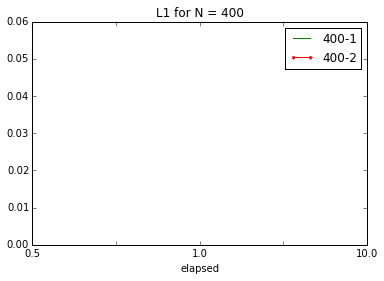

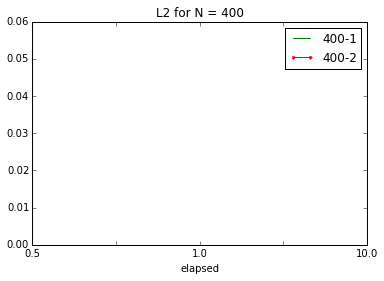

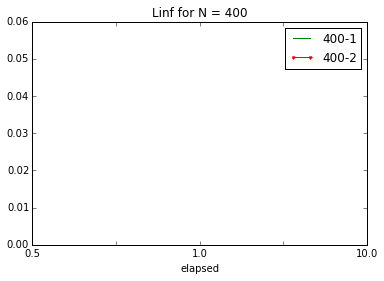

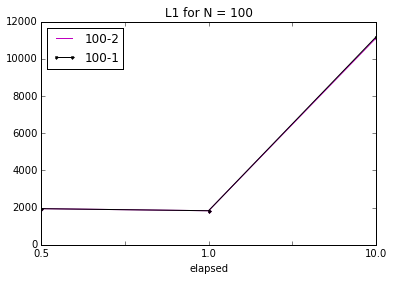

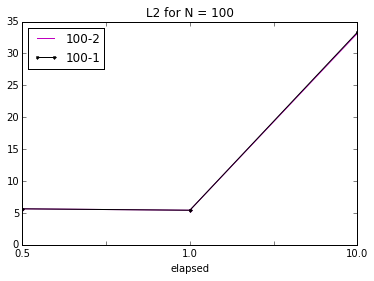

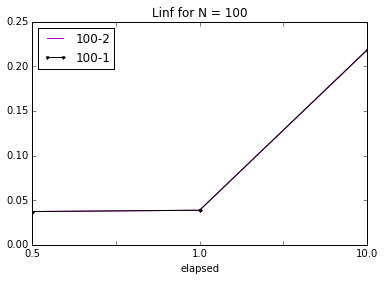

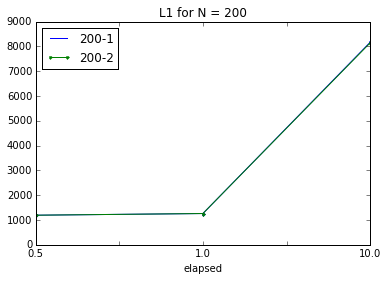

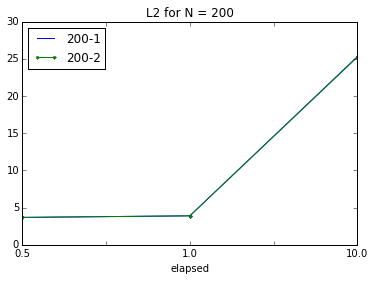

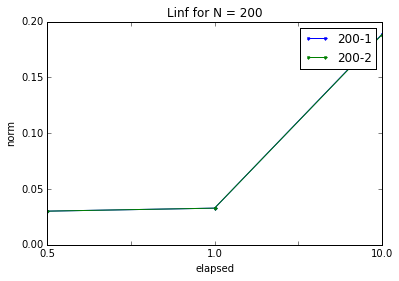

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle
cycol = cycle('bgrcmk').next

print simulations

best_nx, best_sweeps = best_key.split('-')
temp_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(best_nx, best_sweeps))
color = cycol()
# ax = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.')
# temp_frame.plot('elapsed', 'L2', kind='line', ax = ax, ylim=0, c=color, marker='o')
# temp_frame.plot('elapsed', 'Linf', kind='line', ax = ax, ylim=0, c=color, marker='*')

graph_grids = []
for key in simulations:
    if key != best_key:
        nx, sweeps = key.split('-')
#         print 'Cells = ', nx
#         print 'Sweeps = ', sweeps
        color = cycol()
        temp_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(nx, sweeps))
        if nx not in graph_grids:
            print 'yay'
            graph_grids.append(nx)
            if int(nx)==100:
#                 print '100 yayyyyyyyyyyyyyyyyyyy'
                grids_100_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 100', label=key)
                grids_100_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.',
                                               title='L2 for N = 100', label=key)
                grids_100_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.',
                                                 title='Linf for N = 100', label=key)
            if int(nx)==200:
#                 print '200 yay'
                grids_200_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 200', label=key)
                grids_200_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 200', label=key)
                grids_200_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 200', label=key)
            if int(nx)==400:
#                 print '400 yay'
                grids_400_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 400', label=key)
                grids_400_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 400', label=key)
                grids_400_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 400', label=key)
        else:
            if int(nx)==100:
#                 print 'eleeeeeeeeee yay'
                temp_frame.plot('elapsed', 'L1', ax = grids_100_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 100', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_100_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 100', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_100_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 100', label=key)
            if int(nx)==200:
                temp_frame.plot('elapsed', 'L1', ax = grids_200_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 200', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_200_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 200', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_200_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 200', label=key)
            if int(nx)==400:
                temp_frame.plot('elapsed', 'L1', ax = grids_400_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 400', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_400_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 400', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_400_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 400', label=key)
                
    
plt.ylabel('Norm')
plt.xlabel('Elapsed Time')
plt.legend()
            

# cvar Figures of Merit

Now we have everything we need in the dataframe and can compare the different grid sizes, calculate L2 using cvar etc

# Free Energy Interpolation

For this section, we have to take the elapsed time and cvar from each step file, calculate the energy at that step, then interpolate the array of energies along with time. Save the intepolated function into the SUMATRA dataframe

In [223]:
energyFunctions = []
energyFunctions.append(None)
print energyFunctions
print ' '
for row in df.iterrows():
    print row[1]['label']
    
df

#How to select a specific row and then you can change the values in it's columns
df.loc[df['label']==['bf22b1bfaef6']['datastore']

[None]
 
48841eea4a91
da25c86b72f0
bf22b1bfaef6
7f52183544f2
47235abe3a7b


2    {u'type': u'FileSystemDataStore', u'parameters...
Name: datastore, dtype: object

In [191]:
!pwd

/data/aem1/new1a/corr-sumatra-test


In [35]:
import os
import numpy as np
from scipy import interpolate as scpinter

results = {}
c_alpha = 0.3
c_beta = 0.7
kappa = 2.0
# M = 5.0
# c_0 = 0.5
# epsilon = 0.01
rho_s = 5.0

def f_0(c):
    return rho_s*((c - c_alpha)**2)*((c_beta-c)**2)

def f(c):
    return (f_0(c)+ .5*kappa*(np.linalg.norm(np.gradient(c)))**2)


def freeEnergyInterp(labels, dframe, Lx = 200):
    energyFunctions = []
    #This code will access every step file saved in the Data/[label] directory 
    for label in dframe['label']:
        e_elaps = []
        e_enrg = []
        filepath = os.path.join('/data/aem1/new1a/corr-sumatra2/Data', label)
        #gets the last step file in the directory (hopefully at equillibrium)
        file = os.listdir('Data/{0}'.format(label))[len(os.listdir('Data/{0}'.format(label)))-2] 
        stepfiles = glob.glob('{0}/*.npz'.format(filepath)) #get the list of all step files for simulation
        print stepfiles
        if len(stepfiles)==0: 
            energyFunctions.append(None)
        else:
            for stpfile in stepfiles:
                fn = np.load(stpfile)
                #do free enrgy math here

                cvar_array = fn['c_var_array']
                cells = fn['nx']*fn['ny']
                dx = Lx / fn['nx']
                dy = Lx / fn['ny']
                free_energy_array = f(cvar_array)
                free_energy_cellVolAvg = np.mean(free_energy_array)*cells*dx*dy
#                 f(c_var).cellVolumeAverage*cells*(dx**2)


                e_elaps.append(fn['elapsed'])
                e_enrg.append(free_energy_cellVolAvg)

            eFunction = scpinter.interp1d(e_elaps, e_enrg, copy=False)
            energyFunctions.append(eFunction) #save a list of all the energy functions
        print 'Number of energy functions: ', len(energyFunctions)    
    dframe['Free_Energy_Interpolated_Function'] = energyFunctions #add the list as a new column to the dataframe

labels = dfC_final['label']
print labels
freeEnergyInterp(labels, dfC_final)
#             data = {'cvar':fn['cvar'], 'freeEn':float(fn['f']), 'step':int(fn['steps']), 'elapsed':float(fn['time'])}
#     #         print type(data)
#     #         print type(str(fn['grid']))
#             results.update({str(fn['grid']):data})


0     930d7803d43c
1     930d7803d43c
2     930d7803d43c
3     c04ef730f8a4
4     c04ef730f8a4
5     c04ef730f8a4
6     07a1f812ebe3
7     07a1f812ebe3
8     07a1f812ebe3
9     00b64e9db978
10    00b64e9db978
11    00b64e9db978
12    8be118ae3c21
13    8be118ae3c21
14    8be118ae3c21
15    86fba5d0f38f
16    86fba5d0f38f
17    86fba5d0f38f
18    ba1d8960924e
19    ba1d8960924e
20    ba1d8960924e
21    29e7a1c26a03
22    29e7a1c26a03
23    29e7a1c26a03
24    40dbc6ecca1c
25    40dbc6ecca1c
26    40dbc6ecca1c
Name: label, dtype: object
['/data/aem1/new1a/corr-sumatra2/Data/930d7803d43c/1a_400_step000000_data_time-0.00.npz', '/data/aem1/new1a/corr-sumatra2/Data/930d7803d43c/1a_400_step000018_data_time-0.50.mpz.npz', '/data/aem1/new1a/corr-sumatra2/Data/930d7803d43c/1a_400_step000019_data_time-0.56.npz', '/data/aem1/new1a/corr-sumatra2/Data/930d7803d43c/1a_400_step000025_data_time-1.00.mpz.npz', '/data/aem1/new1a/corr-sumatra2/Data/930d7803d43c/1a_400_step000026_data_time-1.10.npz', '/data

In [36]:
dfC_final

,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf,Free_Energy_Interpolated_Function
0,930d7803d43c,19,0.5,400,400,"[0.50673233667, 0.508385740277, 0.509895251232...",None,0.0440082686508,0.5,0.5,1,NaN,NaN,NaN,<scipy.interpolate.interpolate.interp1d object...
1,930d7803d43c,26,1.0,400,400,"[0.506896655988, 0.508563642028, 0.51010800093...",None,0.0710184637685,0.5,0.5,1,NaN,NaN,NaN,<scipy.interpolate.interpolate.interp1d object...
2,930d7803d43c,52,10.0,400,400,"[0.534176225054, 0.541906158813, 0.54898882738...",None,0.14020960391,0.5,0.5,1,NaN,NaN,NaN,<scipy.interpolate.interpolate.interp1d object...
3,c04ef730f8a4,19,0.5,50,50,"[0.531568565867, 0.524867525329, 0.51452037813...",None,0.0440082686508,4.0,4,1,5206.07,13.4047,0.0581749,<scipy.interpolate.interpolate.interp1d object...
4,c04ef730f8a4,26,1.0,50,50,"[0.535429868073, 0.528178117566, 0.51580079118...",None,0.0710184637685,4.0,4,1,5866.3,15.0605,0.0648757,<scipy.interpolate.interpolate.interp1d object...
5,c04ef730f8a4,51,10.0,50,50,"[0.609652339928, 0.605505470278, 0.57235280566...",None,0.459644859611,4.0,4,1,17395.1,48.0488,0.261789,<scipy.interpolate.interpolate.interp1d object...
6,07a1f812ebe3,19,0.5,50,50,"[0.531568565842, 0.52486752533, 0.51452037814,...",None,0.0440082686508,4.0,4,2,5206.07,13.4047,0.0581749,<scipy.interpolate.interpolate.interp1d object...
7,07a1f812ebe3,26,1.0,50,50,"[0.535429867575, 0.528178117559, 0.51580079119...",None,0.0710184637685,4.0,4,2,5866.3,15.0605,0.0648757,<scipy.interpolate.interpolate.interp1d object...
8,07a1f812ebe3,51,10.0,50,50,"[0.608248244075, 0.604199034199, 0.57144701935...",None,0.283249889094,4.0,4,2,17169.2,47.5165,0.260306,<scipy.interpolate.interpolate.interp1d object...
9,00b64e9db978,19,0.5,100,100,"[0.517433869448, 0.522449680241, 0.51992540421...",None,0.0440082686508,2.0,2,2,1943.13,5.64167,0.0372392,<scipy.interpolate.interpolate.interp1d object...


# Figures of Merit

Now we need to use methods to add some figures of merit to the dataframes to compare the grids to the 400 grid

In [ ]:
for row in df.iterrows():

In [42]:
#add moose data as well
#This method takes any set of "ideal times" and compares the free energy values at those times for every simulation

ideal_times = []
for i in xrange(1, 10): ideal_times.append(i)
# ideal_times = [1, 5, 10]
print ideal_times

def FreeEnergyCompare(dframe, ideal_times):
    L1Norms = [] #should these be dictionaries to match with the proper simulation label? 
    L2Norms = []
    LinfNorms = []
    N_Best = 0
    sweeps_Best = 0
    
    for row in dframe.iterrows():
        if row[1]['nx'] > N_Best and row[1]['sweeps'] > sweeps_Best:
            BestEnergyFunct = row[1]['Free_Energy_Interpolated_Function']
            N_Best = row[1]['nx']
            sweeps_Best = row[1]['sweeps']
    for row in dframe.iterrows():    
        efunction = row[1]['Free_Energy_Interpolated_Function']
        diff = np.absolute(efunction(ideal_times) - BestEnergyFunct(ideal_times))
        L1Norms.append(np.linalg.norm(diff,1)) 
        L2Norms.append(np.linalg.norm(diff,2)) 
        LinfNorms.append(np.linalg.norm(diff, np.inf)) 
    
    
    dframe['L1 Free Energy Norms'] = L1Norms
    dframe['L2 Free Energy Norms'] = L2Norms
    dframe['L-infinite Free Energy Norms'] = LinfNorms
    #Anushkas code
#     diff_50.append(np.absolute(y50x4[ideal_times] - y400x5[ideal_times]))
#     L1Norms.append(np.linalg.norm(diff_50,1))
#     L2Norms.append(np.linalg.norm(diff_50,2))
#     LinfNorms.append(np.linalg.norm(diff_50, np.inf))

FreeEnergyCompare(dfC_final, ideal_times)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


# Free  Energy Norm graphing

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import cycle
cycol = cycle('bgrcmk').next

print simulations

best_nx, best_sweeps = best_key.split('-')
temp_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(best_nx, best_sweeps))
color = cycol()
# ax = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.')
# temp_frame.plot('elapsed', 'L2', kind='line', ax = ax, ylim=0, c=color, marker='o')
# temp_frame.plot('elapsed', 'Linf', kind='line', ax = ax, ylim=0, c=color, marker='*')

graph_grids = []
for key in simulations:
    if key != best_key:
        nx, sweeps = key.split('-')
#         print 'Cells = ', nx
#         print 'Sweeps = ', sweeps
        color = cycol()
        temp_frame = dfC_final.query('(nx == {0}) & (sweeps == {1})'.format(nx, sweeps))
        if nx not in graph_grids:
            print 'yay'
            graph_grids.append(nx)
            if int(nx)==100:
#                 print '100 yayyyyyyyyyyyyyyyyyyy'
                Energy_N100_L1_graph = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy L1 for N = 100', label=key)
                Energy_N100_L2_graph = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.',
                                               title='Free Energy L2 for N = 100', label=key)
                Energy_N100_Linf_graph = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.',
                                                 title='Free Energy Linf for N = 100', label=key)
            if int(nx)==200:
#                 print '200 yay'
                grids_200_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy L1 for N = 200', label=key)
                grids_200_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy L2 for N = 200', label=key)
                grids_200_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy Linf for N = 200', label=key)
            if int(nx)==400:
#                 print '400 yay'
                grids_400_L1 = temp_frame.plot('elapsed', 'L1', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy L1 for N = 400', label=key)
                grids_400_L2 = temp_frame.plot('elapsed', 'L2', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy L2 for N = 400', label=key)
                grids_400_Linf = temp_frame.plot('elapsed', 'Linf', kind='line', ylim=0, c=color, marker='.', 
                                               title='Free Energy Linf for N = 400', label=key)
        else:
            if int(nx)==100:
#                 print 'eleeeeeeeeee yay'
                temp_frame.plot('elapsed', 'L1', ax = grids_100_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 100', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_100_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 100', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_100_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 100', label=key)
            if int(nx)==200:
                temp_frame.plot('elapsed', 'L1', ax = grids_200_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 200', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_200_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 200', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_200_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 200', label=key)
            if int(nx)==400:
                temp_frame.plot('elapsed', 'L1', ax = grids_400_L1, kind='line', ylim=0, c=color, marker='.', 
                                               title='L1 for N = 400', label=key)
                temp_frame.plot('elapsed', 'L2', ax = grids_400_L2, kind='line', ylim=0, c=color, marker='.', 
                                               title='L2 for N = 400', label=key)
                temp_frame.plot('elapsed', 'Linf', ax = grids_400_Linf, kind='line', ylim=0, c=color, marker='.', 
                                               title='Linf for N = 400', label=key)
                
    
plt.ylabel('norm')
plt.xlabel('elapsed')
plt.legend()

,label,steps,elapsed,nx,ny,c_var_array,cvar_Interpolated_Function,dt,dx,dy,sweeps,L1,L2,Linf,Free_Energy_Interpolated_Function,L1 Free Energy Norms,L2 Free Energy Norms,L-infinite Free Energy Norms
0,930d7803d43c,19,0.5,400,400,"[0.50673233667, 0.508385740277, 0.509895251232...",None,0.0440082686508,0.5,0.5,1,NaN,NaN,NaN,<scipy.interpolate.interpolate.interp1d object...,0.000000,0.000000,0.000000
1,930d7803d43c,26,1.0,400,400,"[0.506896655988, 0.508563642028, 0.51010800093...",None,0.0710184637685,0.5,0.5,1,NaN,NaN,NaN,<scipy.interpolate.interpolate.interp1d object...,0.000000,0.000000,0.000000
2,930d7803d43c,52,10.0,400,400,"[0.534176225054, 0.541906158813, 0.54898882738...",None,0.14020960391,0.5,0.5,1,NaN,NaN,NaN,<scipy.interpolate.interpolate.interp1d object...,0.000000,0.000000,0.000000
3,c04ef730f8a4,19,0.5,50,50,"[0.531568565867, 0.524867525329, 0.51452037813...",None,0.0440082686508,4.0,4,1,5206.07,13.4047,0.0581749,<scipy.interpolate.interpolate.interp1d object...,321440.977996,125686.991715,69643.988079
4,c04ef730f8a4,26,1.0,50,50,"[0.535429868073, 0.528178117566, 0.51580079118...",None,0.0710184637685,4.0,4,1,5866.3,15.0605,0.0648757,<scipy.interpolate.interpolate.interp1d object...,321440.977996,125686.991715,69643.988079
5,c04ef730f8a4,51,10.0,50,50,"[0.609652339928, 0.605505470278, 0.57235280566...",None,0.459644859611,4.0,4,1,17395.1,48.0488,0.261789,<scipy.interpolate.interpolate.interp1d object...,321440.977996,125686.991715,69643.988079
6,07a1f812ebe3,19,0.5,50,50,"[0.531568565842, 0.52486752533, 0.51452037814,...",None,0.0440082686508,4.0,4,2,5206.07,13.4047,0.0581749,<scipy.interpolate.interpolate.interp1d object...,336374.031220,131610.106649,72962.444352
7,07a1f812ebe3,26,1.0,50,50,"[0.535429867575, 0.528178117559, 0.51580079119...",None,0.0710184637685,4.0,4,2,5866.3,15.0605,0.0648757,<scipy.interpolate.interpolate.interp1d object...,336374.031220,131610.106649,72962.444352
8,07a1f812ebe3,51,10.0,50,50,"[0.608248244075, 0.604199034199, 0.57144701935...",None,0.283249889094,4.0,4,2,17169.2,47.5165,0.260306,<scipy.interpolate.interpolate.interp1d object...,336374.031220,131610.106649,72962.444352
9,00b64e9db978,19,0.5,100,100,"[0.517433869448, 0.522449680241, 0.51992540421...",None,0.0440082686508,2.0,2,2,1943.13,5.64167,0.0372392,<scipy.interpolate.interpolate.interp1d object...,737422.389702,290301.538867,161691.572364


In [30]:
print len(df['output_data'][0])

4


In [31]:
for p in 'N', 'steps', 'sweeps':
    df[p] = df.parameters.map(lambda x: json.loads(x['content'])[p])

In [ ]:
print df['parameters'][0]['content']

In [37]:
df['Free Energy']=results['10x1']['freeEn']
df['elapsed']=results['10x1']['elapsed']

columns.append('Free Energy')
columns.append('elapsed')
df[columns]

,label,N,steps,tags,duration,sweeps,memory,Free Energy,elapsed
0,8f1f49c60b96,10,20,[npzTest],4.042712,2,4648.0,0.786517,0.57275


In [33]:
columns = ['label', 'N', 'steps', 'tags', 'duration', 'sweeps']
print df[columns]

          label   N  steps       tags  duration  sweeps
0  8f1f49c60b96  10     20  [npzTest]  4.042712       2


In [34]:
import numpy as np
import os
num = 0
memoryArray = np.array([])
for num in range(len(df.index)):
    memName = df['output_data'][num][len(df['output_data'][num])-1]['path']
    memlocation = df['datastore'][num]['parameters']['root']
    pool = os.path.join(memlocation, memName)
    memdata = np.loadtxt(pool)
    memoryArray = np.append(memoryArray, memdata)
    print memoryArray
    print ' '
    print num

[ 4648.]
 
0


In [35]:
df['memory']=memoryArray
columns.append('memory')
df[columns]

,label,N,steps,tags,duration,sweeps,memory
0,8f1f49c60b96,10,20,[npzTest],4.042712,2,4648.0


In [38]:
data = {'a' : [1, 2, 3], 'b' : [4, 5, 6]}
pandas.DataFrame(data)

,a,b
0,1,4
1,2,5
2,3,6


In [59]:
data = [{'a' : 1, 'b' : 4}, {'a' : 2, 'b' : 5}, {'a' : 3 ,'b' : 6}]
aa  = pandas.DataFrame(data)

In [60]:
def recalc(row):
    return row.b * 2

In [61]:
print aa

   a  b
0  1  4
1  2  5
2  3  6


In [ ]:
aa['c'] = [recalc(row) for index, row in aa.iterrows()]
print aa

In [73]:
times = np.array([0., 1.0, 1.5])
values = times**2


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(times, values)

In [ ]:
import numpy as np
np.linspace(0., 100., 1000)

In [83]:
!ls Data/1de38ff12ec7/
import glob
glob.glob('Data/1de38ff12ec7/*.npz')

1a10x1step0.npz  1a10x1step10.npz  1a10x1step20.npz  memory_usage.txt


['Data/1de38ff12ec7/1a10x1step0.npz',
 'Data/1de38ff12ec7/1a10x1step10.npz',
 'Data/1de38ff12ec7/1a10x1step20.npz']

In [ ]:
cvar_times = []
#smtfram is the datafram created by sumatra records
#dframe is the table we create from .mpz.npz files because it can have multiple entries for the same simulation in order to compare the concentration values at different times
def CvarCompare(dframe, smtframe, Lx=200):
    L1_cvar_Norms = [] #should these be dictionaries to match with the proper simulation label? 
    L2_cvar_Norms = []
    Linf_cvar_Norms = []
    N_Best = 0
    sweeps_Best = 0
    
    labels = smtframe['label']
    
    times = []
    for x in dframe['elapsed']: times.append(int(x))
    times = list(set(times)) 
    print times
    for x in range(len(times)):
        times[x] = int(times[x]) #a list of the unique times where we sampled c_var
    
    times = [0.5, 1.0, 10.0] #manually entered these because it was crashing when one of the times was 0.5 seconds and rounding to 0
    print times
    
    L1_cvar_times = dict(('L1_cvar_time_{0}'.format(time), []) for time in times)
    L2_cvar_times = dict(('L2_cvar_time_{0}'.format(time), []) for time in times)
    Linf_cvar_times = dict(('Linf_cvar_time_{0}'.format(time), []) for time in times)

    print 'L1: '
    print L1_cvar_times
    print 'L2: '
    print L2_cvar_times
    print 'Linf: '
    print Linf_cvar_times
    #first we need to figure out which is the finest grid to set it as the standard of comparison
    for row in dframe.iterrows():
        if row[1]['nx']>N_Best and row[1]['sweeps']>sweeps_Best:
            Best_cvar_function = row[1]['cvar_Interpolated_Function']
            N_Best = row[1]['nx']
            sweeps_Best = row[1]['sweeps']
    #now for every sumatra label, go thorugh the dframe, and make lists for each norm and each sampled time 
    for label in labels:
        for row in dframe.iterrows():  
            if row[1]['label']==label:
                cvar_function = row[1]['cvar_Interpolated_Function']
                elapsed = row[1]['elapsed']
                nx = row[1]['nx']
                ny = row[1]['ny']
                m = fp.Grid2D(nx = nx, ny= ny, dx=Lx / nx, dy=Lx / ny)
                x = m.x
                y = m.y
                diff = np.absolute(cvar_function(x,y) - Best_cvar_function(x,y))
                
                L1_cvar_times['L1_cvar_time_{0}'.format(elapsed)].append(np.linalg.norm(diff,1))
                L2_cvar_times['L2_cvar_time_{0}'.format(elapsed)].append(np.linalg.norm(diff,2))
                Linf_cvar_times['Linf_cvar_time_{0}'.format(elapsed)].append(np.linalg.norm(diff,np.inf))

                
    #add the norms data to the sumatra database as seperate columns             
    for key in L1_cvar_times.keys():
        smtframe[key] = L1_cvar_times[key]
    for key in L2_cvar_times.keys():
        smtframe[key] = L2_cvar_times[key]         
    for key in Linf_cvar_times.keys():
        smtframe[key] = Linf_cvar_times[key]    
                 
    return smtframe
#                 try:
#                     L1_cvar_time_{0}.format(elapsed).append(np.linalg.norm(diff,1))
#                     L2_cvar_time_{0}.format(elapsed).append(np.linalg.norm(diff,2))
#                     L3_cvar_time_{0}.format(elapsed).append(np.linalg.norm(diff,3))
#                 except:
#                     L1_cvar_time_{0}.format(elapsed)=[np.linalg.norm(diff,1)]
#                     L2_cvar_time_{0}.format(elapsed)=[np.linalg.norm(diff,2)]
#                     L3_cvar_time_{0}.format(elapsed)=[np.linalg.norm(diff,3)]
#     for x in times:
#         smtframe['L1_cvar_time_{0}'.format(x)] = L1_cvar_time_{0}.format(x)
#         smtframe['L2_cvar_time_{0}'.format(x)] = L2_cvar_time_{0}.format(x)
#         smtframe['L3_cvar_time_{0}'.format(x)] = L3_cvar_time_{0}.format(x)
 
        
#     smtframe['L1 cvar Norms time:{0}'] = L1Norms
#     smtframe['L2 Norms'] = L2Norms
#     smtframe['L-infinite Norms'] = LinfNorms
#     return True
                 
CvarCompare(dfC, df)